In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


In [19]:
import pandas as pd

import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
import scipy.stats as ss
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import plotly.express as px
from tabulate import tabulate


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
class MetastaticDiagnosis:
    def __init__(self):
        self.train_df = None
        self.test_df = None

    def read_data(self,train_csv,val_csv,test_csv):
        self.train_df = pd.read_csv(train_csv)
        self.test_df = pd.read_csv(test_csv)
        self.val_df = pd.read_csv(val_csv)
        return self.train_df, self.val_df, self.test_df

    def get_column_info(self):
        data_types = self.train_df.dtypes
        categorical_cols = self.train_df.select_dtypes(include=['object', 'category']).columns.tolist()

        numerical_cols = self.train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

        if "patient_zip3" in numerical_cols:
          numerical_cols.remove("patient_zip3")

        if "patient_zip3" not in categorical_cols:
          categorical_cols.append("patient_zip3")
        return categorical_cols, numerical_cols

    def impute_data(self):
      _, numerical_cols = self.get_column_info()
      num_imputer = SimpleImputer(strategy='mean')

      if self.train_df is not None:
        self.train_df[numerical_cols] = num_imputer.fit_transform(self.train_df[numerical_cols])
      if self.val_df is not None:
        self.val_df[numerical_cols] = num_imputer.transform(self.val_df[numerical_cols])

      return self.train_df, self.val_df

    def select_top_features(self, df):
        selected_features = [
        "patient_id", "breast_cancer_diagnosis_code", "patient_age",
        "metastatic_cancer_diagnosis_code", "payer_type", "patient_race",
        "patient_zip3", "patient_state", "income_household_25_to_35",
        "rent_burden", "income_household_under_5","DiagPeriodL90D"
        ]

        return df[selected_features]

    def identify_variable_types(self, dataframe):
        """
        Identifies numerical and categorical variables in the dataframe.

        Parameters:
        - dataframe: A pandas DataFrame.

        Returns:
        - Two lists: one containing numerical variable names and the other containing categorical variable names.
        """
        df_data_types = dataframe.dtypes

        continuous_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns.tolist()

        categorical_cols = dataframe.select_dtypes(include=['object']).columns.tolist()

        if 'patient_zip3' in continuous_cols:
          continuous_cols.remove('patient_zip3')
        if 'patient_zip3' not in categorical_cols:
          categorical_cols.append('patient_zip3')

        return continuous_cols, categorical_cols

    def scale_continuous_features(self, train_df, val_df, continuous_columns, columns_to_exclude):
        columns_to_scale = [col for col in continuous_columns if col not in columns_to_exclude]

        scaler = MinMaxScaler((0, 1)).fit(train_df[columns_to_scale])

        train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
        val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])

        return train_df, val_df

    def preprocess_data(self, df, train_columns, categorical_columns):
        df_encoded = pd.get_dummies(df, columns=categorical_columns)

        if train_columns is not None:
            for col in set(train_columns) - set(df_encoded.columns):
                df_encoded[col] = 0

            extra_cols = set(df_encoded.columns) - set(train_columns)
            df_encoded = df_encoded.drop(columns=extra_cols, errors='ignore')

            df_encoded = df_encoded.reindex(columns=train_columns, fill_value=0)

        return df_encoded

    def preprocess_and_shuffle(self, df, target_column, is_fit=False):
        """
        Preprocesses the given dataframe, shuffles the data, and separates the target variable.

        Args:
        df (DataFrame): The DataFrame containing the text data and other features.
        target_column (str): The name of the target column.
        is_fit (bool): If True, fit the preprocessor on the data.

        Returns:
        ndarray: An array of processed and shuffled features.
        Series: The shuffled target variable.
        """
        patient_id = df['patient_id'].values

        features = df.drop(columns=['patient_id', target_column])

        processed_features, target = shuffle(features, df[target_column], random_state=42)

        return processed_features, target, patient_id

train_val_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Hamsini/imputed_values/'
test_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Test/'


meta_obj = MetastaticDiagnosis()

train_csv = train_val_path + 'train_df.csv'
val_csv = train_val_path + 'val_df.csv'
test_csv = test_path + 'test.csv'

train_df, val_df, test_df = meta_obj.read_data(train_csv, val_csv, test_csv)



# missing_columns = set(val_df.columns) - set(train_df.columns)
# print("Column(s) missing in train_df:", missing_columns)

print("Train data shape :", train_df.shape, "\n")
print("Val data shape :", val_df.shape, "\n")

print("Test data shape:", test_df.shape, "\n")


train_df, val_df = meta_obj.impute_data()

missing_columns = set(val_df.columns) - set(train_df.columns)
print("Column(s) missing in train_df:", missing_columns)
val_df = val_df.drop(columns='predicted_patient_state')

print("Train data shape after imputation:", train_df.shape)
print("Validation data shape after imputation:", val_df.shape, "\n")

train_df_selected = meta_obj.select_top_features(train_df)
val_df_selected = meta_obj.select_top_features(val_df)
print("Train data shape after feature selection:", train_df_selected.shape)
print("Validation data shape after feature selection:", val_df_selected.shape,"\n")

train_df = train_df.drop('Unnamed: 0', axis=1)
val_df = val_df.drop('Unnamed: 0', axis=1)


continuous_cols, category_cols = meta_obj.identify_variable_types(train_df_selected)
print("Continuous columns:", continuous_cols)
print("Categorical columns:", category_cols,"\n")

continuous_cols_to_exclude = ['patient_id', 'DiagPeriodL90D']
train_df_scaled, val_df_scaled = meta_obj.scale_continuous_features(train_df_selected, val_df_selected, continuous_cols, continuous_cols_to_exclude)
print("After scaling train data ",train_df_scaled.shape)
print("After scaling val data", val_df_scaled.shape, "\n")

X_train, y_train, train_patient_id = meta_obj.preprocess_and_shuffle(train_df_scaled, 'DiagPeriodL90D', is_fit=True)

# Transform validation data
X_val, y_val, val_patient_id = meta_obj.preprocess_and_shuffle(val_df_scaled, 'DiagPeriodL90D', is_fit=False)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape, "\n")


Train data shape : (10324, 82) 

Val data shape : (2582, 83) 

Test data shape: (5792, 82) 

Column(s) missing in train_df: {'predicted_patient_state'}
Train data shape after imputation: (10324, 82)
Validation data shape after imputation: (2582, 82) 

Train data shape after feature selection: (10324, 12)
Validation data shape after feature selection: (2582, 12) 

Continuous columns: ['patient_id', 'patient_age', 'income_household_25_to_35', 'rent_burden', 'income_household_under_5', 'DiagPeriodL90D']
Categorical columns: ['breast_cancer_diagnosis_code', 'metastatic_cancer_diagnosis_code', 'payer_type', 'patient_race', 'patient_state', 'patient_zip3'] 

After scaling train data  (10324, 12)
After scaling val data (2582, 12) 

X_train shape:  (10324, 10)
y_train shape:  (10324,)
X_val shape:  (2582, 10)
y_val shape:  (2582,) 



<ipython-input-39-59846b224035>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])


0:	total: 27.6ms	remaining: 24.8s
10:	total: 418ms	remaining: 33.8s
20:	total: 698ms	remaining: 29.2s
30:	total: 1.04s	remaining: 29.1s
40:	total: 1.33s	remaining: 27.8s
50:	total: 1.61s	remaining: 26.9s
60:	total: 1.95s	remaining: 26.8s
70:	total: 2.22s	remaining: 25.9s
80:	total: 2.65s	remaining: 26.8s
90:	total: 3.06s	remaining: 27.2s
100:	total: 3.66s	remaining: 28.9s
110:	total: 4.19s	remaining: 29.8s
120:	total: 4.61s	remaining: 29.7s
130:	total: 4.98s	remaining: 29.2s
140:	total: 5.35s	remaining: 28.8s
150:	total: 5.71s	remaining: 28.3s
160:	total: 6.09s	remaining: 28s
170:	total: 6.46s	remaining: 27.5s
180:	total: 6.78s	remaining: 27s
190:	total: 7.11s	remaining: 26.4s
200:	total: 7.44s	remaining: 25.9s
210:	total: 7.66s	remaining: 25s
220:	total: 7.93s	remaining: 24.4s
230:	total: 8.28s	remaining: 24s
240:	total: 8.59s	remaining: 23.5s
250:	total: 8.88s	remaining: 23s
260:	total: 9.21s	remaining: 22.5s
270:	total: 9.46s	remaining: 21.9s
280:	total: 9.71s	remaining: 21.4s
290:	

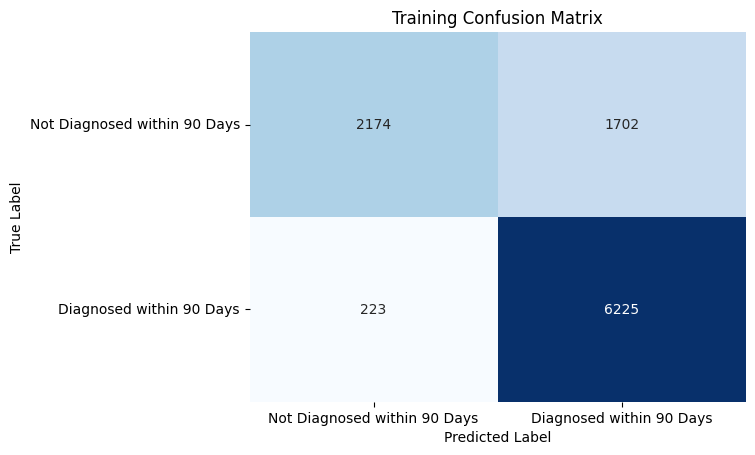

Validation Classification Report:
                               precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.90      0.55      0.68       970
    Diagnosed within 90 Days       0.78      0.96      0.86      1612

                    accuracy                           0.81      2582
                   macro avg       0.84      0.76      0.77      2582
                weighted avg       0.82      0.81      0.79      2582



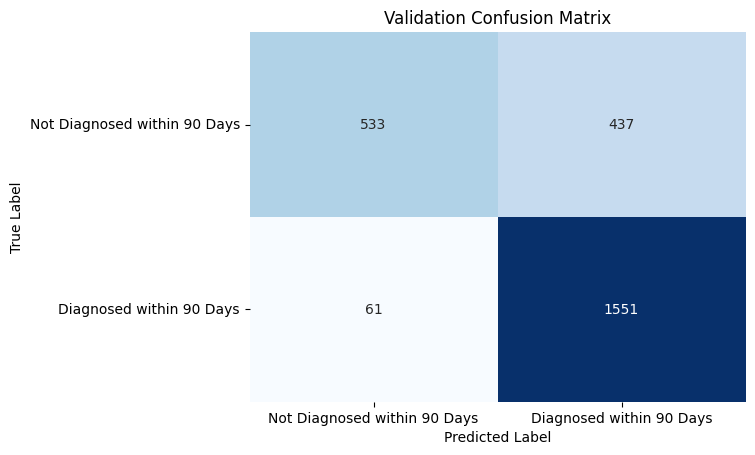


 ROC Curve


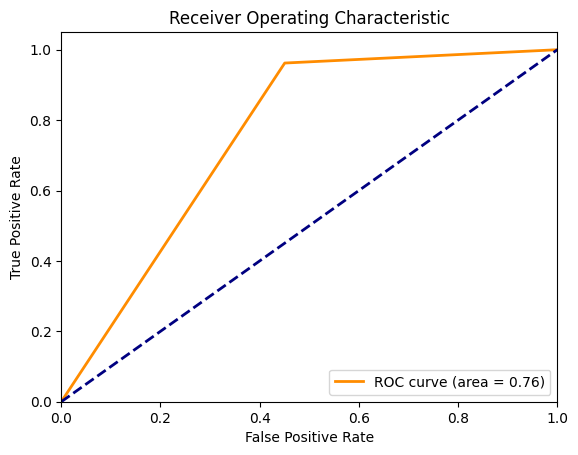

In [41]:

class ModelBuilder:
    def __init__(self):
        self.cf_classifier = None

    def build_catboost_classifier(self):
        cf_classifier = CatBoostClassifier(
        iterations=900,
        learning_rate=0.0001,
        depth=5,
        l2_leaf_reg=3,
        border_count=32,
        random_strength=1,
        bagging_temperature=0,
        od_type='Iter',
        auto_class_weights=None,
        leaf_estimation_method='Newton',
        subsample=0.66,
        min_data_in_leaf=1,
        loss_function='Logloss',
        eval_metric='AUC',
        grow_policy='SymmetricTree',
        early_stopping_rounds=50,
        task_type='CPU',
        verbose=10
)

        self.cf_classifier = cf_classifier

    def train(self, X_train, y_train, category_cols):
        if self.cf_classifier is not None:
            self.cf_classifier.fit(X_train, y_train, cat_features=category_cols)
        else:
            raise ValueError("Model has not been built yet.")
        return self.cf_classifier

    def generate_submission(self, X_val, y_val, val_patient_id, original_val_df, result_path):
      if self.cf_classifier is None:
        raise ValueError("Model has not been built yet.")

      val_yhat_probs_sub = self.cf_classifier.predict_proba(X_val)
      val_yhat_probs = self.cf_classifier.predict(X_val)

      original_val_df.reset_index(drop=True, inplace=True)

      submission = pd.DataFrame({
        'patient_id': val_patient_id,
        'DiagPeriodL90D_actual': y_val,
        'prediction': val_yhat_probs,
        'prediction_probability': val_yhat_probs_sub[:, 1],
        'breast_cancer_diagnosis_code': original_val_df['breast_cancer_diagnosis_code'],
        'patient_age': original_val_df['patient_age'],
        'metastatic_cancer_diagnosis_code': original_val_df['metastatic_cancer_diagnosis_code'],
        'patient_race': original_val_df['patient_race'],
        'patient_zip3': original_val_df['patient_zip3'],
        'patient_state': original_val_df['patient_state'],
        'payer_type': original_val_df['payer_type'],
        'income_household_25_to_35': original_val_df['income_household_25_to_35'],
        'rent_burden': original_val_df['rent_burden'],
        'income_household_under_5': original_val_df['income_household_under_5']
      })

      # Save the complete submission file
      submission.to_csv(result_path + 'catboost_submission.csv', index=False)

      # Filter for errors where actual and prediction do not match
      errors_only = submission[submission['DiagPeriodL90D_actual'] != submission['prediction']]

      # Save the errors-only submission file
      errors_only.to_csv(result_path + 'catboost_submission_errors.csv', index=False)

      return submission, errors_only


    def calculate_training_classification_report(self, y_train, train_yhat_probs,classes):
        report = classification_report(y_train, train_yhat_probs, target_names=classes)
        return report

    def plot_training_confusion_matrix(self, y_train, train_yhat_probs, classes):
        train_cm = confusion_matrix(y_train, train_yhat_probs)
        ax = sns.heatmap(train_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Training Confusion Matrix')
        plt.show()

    def calculate_validation_classification_report(self, y_val, val_yhat_probs, classes):
        report = classification_report(y_val, val_yhat_probs, target_names=classes)
        return report

    def plot_validation_confusion_matrix(self, y_val, val_yhat_probs, classes):
        val_cm = confusion_matrix(y_val, val_yhat_probs)
        ax = sns.heatmap(val_cm,
                         annot=True,
                         fmt='.0f',
                         cmap='Blues',
                         xticklabels=classes,
                         yticklabels=classes,
                         cbar=False)
        ax.set(xlabel='Predicted Label', ylabel='True Label')
        plt.title('Validation Confusion Matrix')
        plt.show()

    def plot_roc_curve(self, y_true, y_scores):
      """
      Plot the Receiver Operating Characteristic (ROC) curve.

      Args:
      y_true (array-like): True binary labels.
      y_scores (array-like): Target scores, can either be probability estimates of the positive class or confidence values.

      Returns:
      None (displays the ROC curve plot).
      """
      fpr, tpr, _ = roc_curve(y_true, y_scores)
      roc_auc = auc(fpr, tpr)

      plt.figure()
      plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic')
      plt.legend(loc="lower right")
      plt.show()



model_trainer = ModelBuilder()

model_trainer.build_catboost_classifier()

cf_classifier = model_trainer.train(X_train, y_train, category_cols)

result_path = '/content/drive/MyDrive/HS/prediction/'
model_trainer.generate_submission(X_val, y_val, val_patient_id, val_df_selected, result_path)


train_yhat_probs = cf_classifier.predict(X_train)
val_yhat_probs = cf_classifier.predict(X_val)

classes = ["Not Diagnosed within 90 Days", "Diagnosed within 90 Days"]


train_classification_report = model_trainer.calculate_training_classification_report(y_train, train_yhat_probs,classes)
print("Training Classification Report:\n", train_classification_report)

model_trainer.plot_training_confusion_matrix(y_train, train_yhat_probs,classes)


val_classification_report = model_trainer.calculate_validation_classification_report(y_val, val_yhat_probs,classes)
print("Validation Classification Report:\n", val_classification_report)

model_trainer.plot_validation_confusion_matrix(y_val, val_yhat_probs,classes)

print("\n ROC Curve")
y_true = y_val
y_scores = val_yhat_probs
model_trainer.plot_roc_curve(y_true, y_scores)